In [75]:
import pandas as pd
import numpy as np
import re
from konlpy.tag import Okt
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


#### 데이터 불러오기 및 가게이름 전처리

In [47]:
df = pd.read_csv("naver_store_reviews.csv")

In [48]:
df['가게이름'] = df['가게이름'].apply(lambda x: re.sub(r'_\d+$', '', x))

In [49]:
df['가게이름'].unique()

array(['방앗간_담음', '방앗간아이', '전라도청년'], dtype=object)

#### 텍스트 전처리

In [50]:
okt = Okt()

In [51]:
# 불용어 제거
stopwords = ['들기름', '참기름', '꼬순집', '기름', '방앗간', '주문', '구입', '구매', '최고', '진짜', '정말', '계속', '사용', '이번', '여기', '가루', '고춧가루', '고추', 
             '굿', '굿굿', '그냥', '아주', '벌써', '달라', '기분', '처음', '보고', '마늘'
             '예정', '완전', '역시', '일단', '스토어', '제품', '항상', '배송', '청년', '전혀', '오늘', '위해', '자마자', '의사', 
             '생강', '숟가락', '지리산', '농부', '한번']

In [52]:
# def clean_text(text):
#     tokens = okt.nouns(text)
#     tokens = [word for word in tokens if word not in stopwords and len(word) > 1]
#     return tokens
# df['토큰'] = df['리뷰내용'].apply(clean_text)

In [53]:
def extract_meaningful_words(text):
    tagged = okt.pos(text, stem=True)
    allowed_pos = ['Noun', 'Adjective'] 
    tokens = [word for word, pos in tagged if pos in allowed_pos and len(word) > 1]
    tokens = [word for word in tokens if word not in stopwords and len(word) > 1]
    return tokens

df['토큰'] = df['리뷰내용'].apply(extract_meaningful_words)

In [54]:
def clean_and_parse_date(date_str):
    date_str = date_str.strip().rstrip('.')  # 공백 제거 + 끝의 마침표 제거
    year, month, day = date_str.split('.')
    year = int(year)
    if year < 100:
        year += 2000  # 25 → 2025
    return pd.to_datetime(f"{year}-{month}-{day}")

df['작성일'] = df['작성일'].apply(clean_and_parse_date)

In [55]:
df['연도'] = df['작성일'].dt.year
df['월'] = df['작성일'].dt.month
df['일'] = df['작성일'].dt.day
df['요일'] = df['작성일'].dt.day_name()

In [56]:
df.head()

,가게이름,리뷰내용,평점,작성일,토큰,연도,월,일,요일
0,방앗간_담음,재구매참기름 고소하고 넘 맛납니다. 두번째구매해요.앞으로도 쭈욱~~,5,2025-06-29,"[고소하다, 두번째, 쭈욱]",2025,6,29,Sunday
1,방앗간_담음,포장도 꼼꼼하고 몇년째 믿고 먹는집이에요~~,5,2025-07-12,"[포장, 꼼꼼하다]",2025,7,12,Saturday
2,방앗간_담음,국산 참기름 믿을 수 있고 맛도 좋아요!!,5,2025-07-10,"[국산, 있다, 좋다]",2025,7,10,Thursday
3,방앗간_담음,재구매다른 곳 꺼는 못 먹겠어요.\n향 좋고 맛있어요.,5,2025-06-11,"[다른, 좋다, 맛있다]",2025,6,11,Wednesday
4,방앗간_담음,재구매항상 믿고 주문하고있습니다,5,2025-06-08,[],2025,6,8,Sunday


#### 리뷰 분석

연도별 리뷰 단어 사용 변화

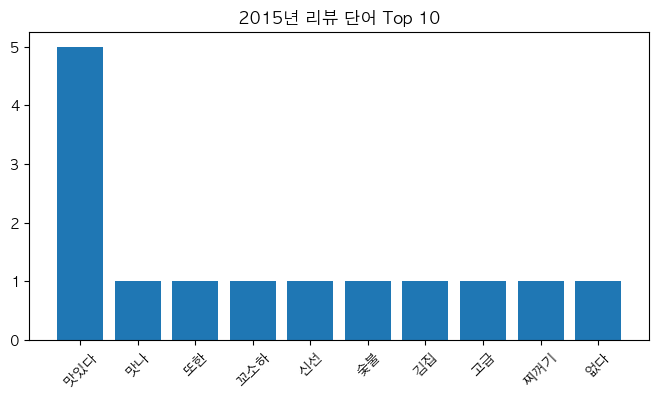

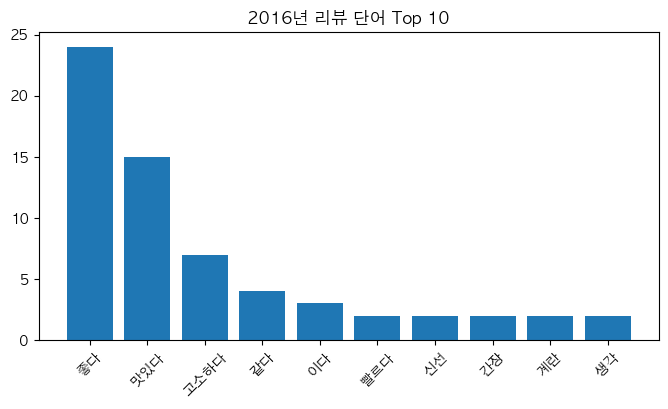

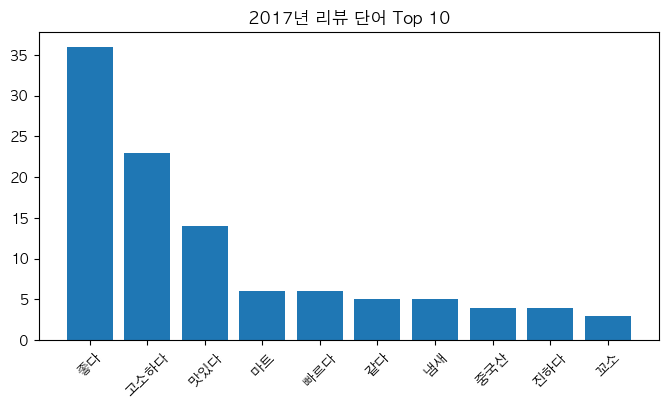

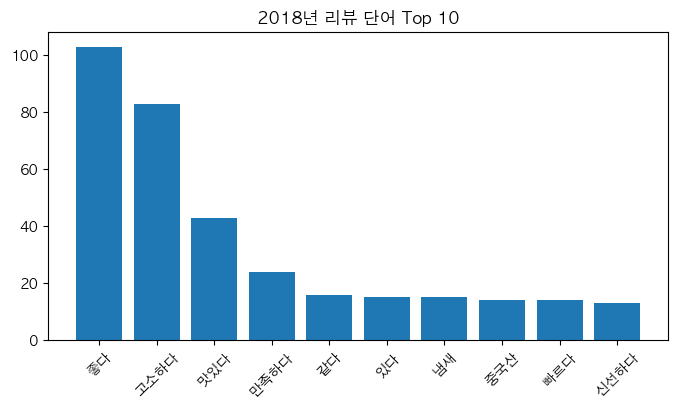

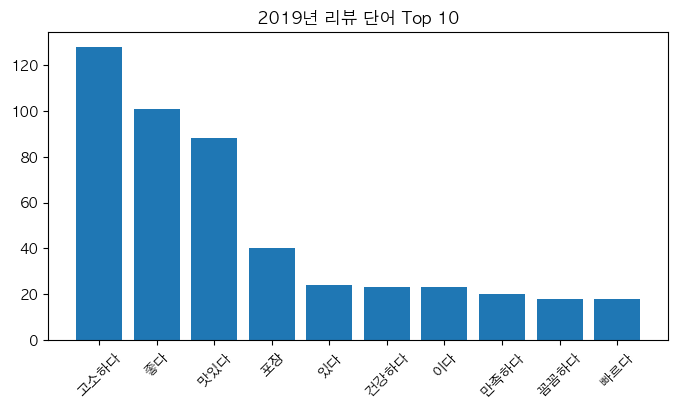

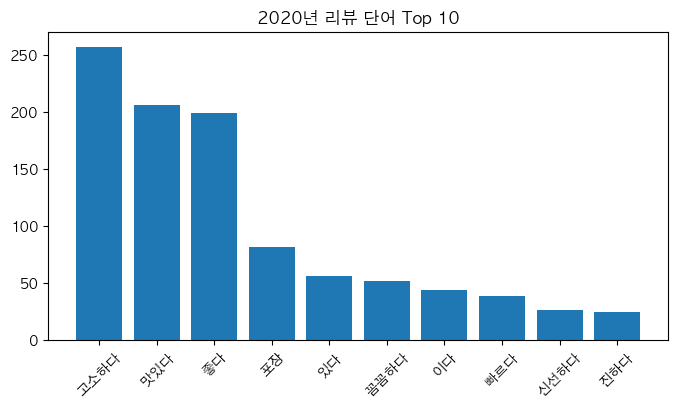

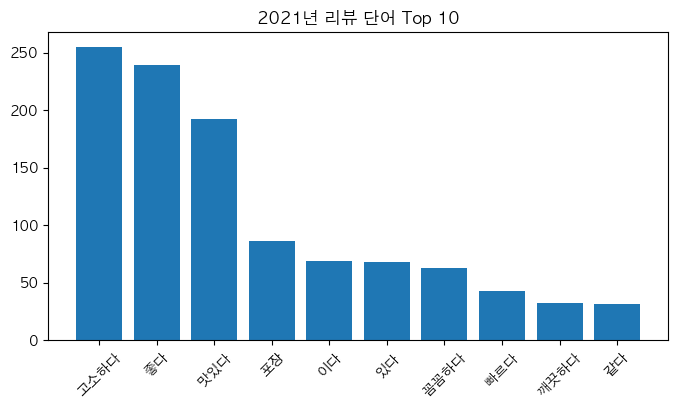

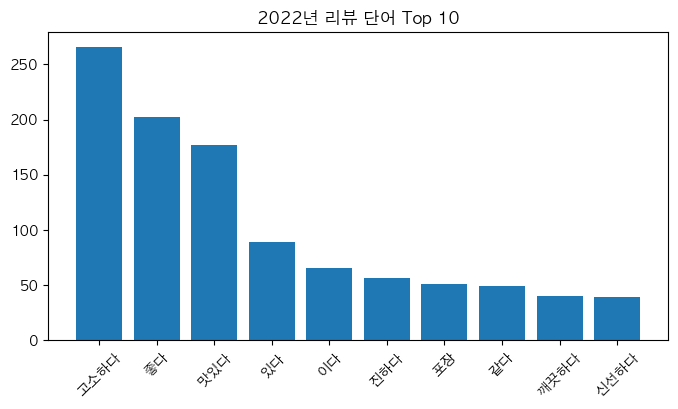

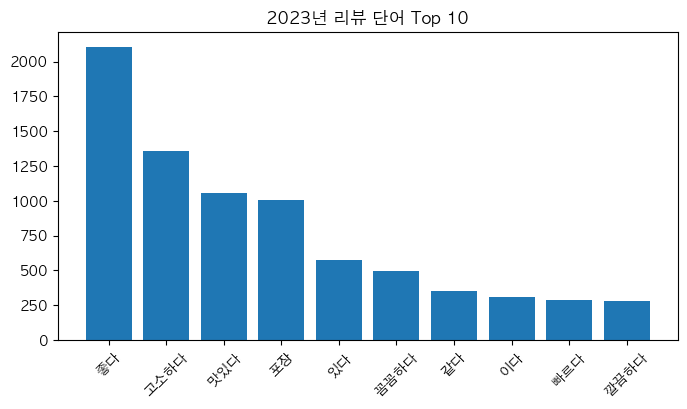

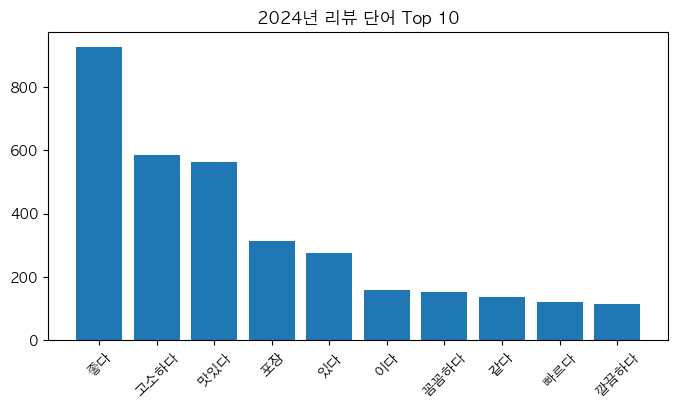

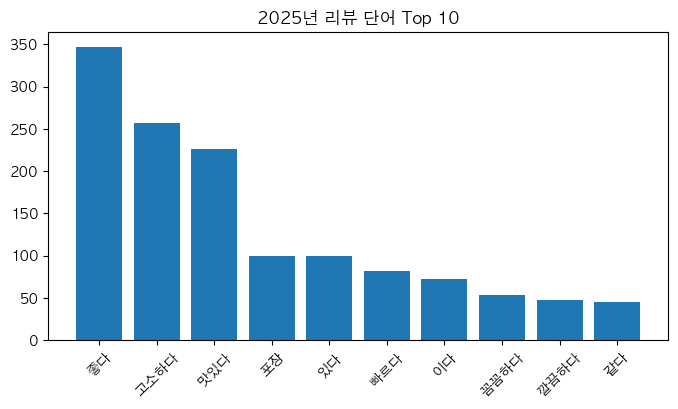

In [68]:
yearly_word_counts = {}

for year in sorted(df['연도'].unique()):
    words = df[df['연도'] == year]['토큰'].sum()
    counter = Counter(words)
    yearly_word_counts[year] = counter.most_common(10)

# 시각화 예시
for year, top_words in yearly_word_counts.items():
    words, counts = zip(*top_words)
    plt.rcParams['font.family'] = 'AppleGothic'
    plt.figure(figsize=(8, 4))
    plt.bar(words, counts)
    plt.title(f'{year}년 리뷰 단어 Top 10')
    plt.xticks(rotation=45)
    plt.show()


가게별 특징 단어 분석

In [69]:
# 토큰을 문자열로 다시 합치기
df['토큰_문자열'] = df['토큰'].apply(lambda x: ' '.join(x))

# TF-IDF 분석
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['토큰_문자열'])

# TF-IDF 결과를 가게별로 평균 낸 후 가장 특징적인 단어 찾기
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
df_tfidf = pd.concat([df[['가게이름']], tfidf_df], axis=1)
mean_tfidf_by_store = df_tfidf.groupby('가게이름').mean()

# 각 가게별로 TF-IDF 가장 높은 단어 Top 5
for store in mean_tfidf_by_store.index:
    top_words = mean_tfidf_by_store.loc[store].sort_values(ascending=False).head(5)
    print(f"🔹 {store} - 특징 단어: {', '.join(top_words.index)}")

🔹 방앗간_담음 - 특징 단어: 좋다, 고소하다, 맛있다, 포장, 국산
🔹 방앗간아이 - 특징 단어: 고소하다, 맛있다, 좋다, 있다, 이다
🔹 전라도청년 - 특징 단어: 좋다, 맛있다, 고소하다, 포장, 있다


평점에 따른 긍정/부정 단어 분석

In [70]:
df['리뷰그룹'] = df['평점'].apply(lambda x: '긍정' if x >= 3.0 else ('부정' if x <= 2.5 else '중립'))

positive_words = df[df['리뷰그룹'] == '긍정']['토큰'].sum()
negative_words = df[df['리뷰그룹'] == '부정']['토큰'].sum()

positive_top = Counter(positive_words).most_common(10)
negative_top = Counter(negative_words).most_common(10)

print("👍 긍정 리뷰 Top 단어:", positive_top)
print("👎 부정 리뷰 Top 단어:", negative_top)


👍 긍정 리뷰 Top 단어: [('좋다', 4276), ('고소하다', 3213), ('맛있다', 2583), ('포장', 1690), ('있다', 1201), ('꼼꼼하다', 872), ('이다', 760), ('같다', 670), ('빠르다', 647), ('깨끗하다', 531)]
👎 부정 리뷰 Top 단어: [('좋다', 9), ('고소하다', 8), ('없다', 6), ('냄새', 5), ('판매', 4), ('그렇다', 4), ('아니다', 4), ('국산', 4), ('다른', 3), ('있다', 3)]


월별 리뷰 수 추이

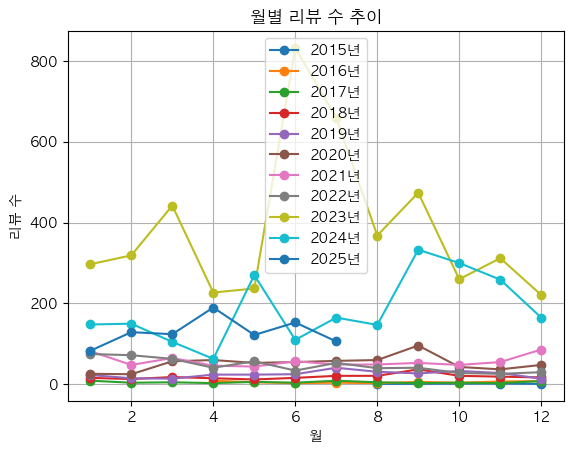

In [71]:
# 월별 리뷰 수 집계
monthly_counts = df.groupby(['연도', '월']).size().reset_index(name='리뷰수')

# 연도별로 선 그래프 그리기
for year in monthly_counts['연도'].unique():
    subset = monthly_counts[monthly_counts['연도'] == year]
    plt.plot(subset['월'], subset['리뷰수'], marker='o', label=f'{year}년')

plt.title('월별 리뷰 수 추이')
plt.xlabel('월')
plt.ylabel('리뷰 수')
plt.legend()
plt.grid(True)
plt.show()


리뷰 길이와 평점 관계

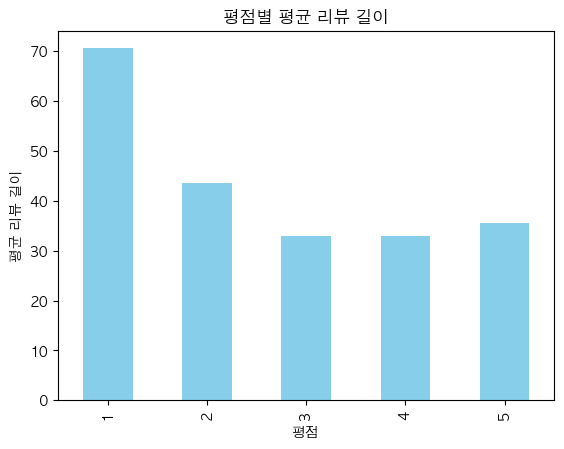

In [72]:
# 리뷰 길이 계산
df['리뷰길이'] = df['리뷰내용'].apply(len)

# 평점에 따른 평균 리뷰 길이
length_by_rating = df.groupby('평점')['리뷰길이'].mean()

# 시각화
length_by_rating.plot(kind='bar', color='skyblue')
plt.title('평점별 평균 리뷰 길이')
plt.xlabel('평점')
plt.ylabel('평균 리뷰 길이')
plt.show()


워드클라우드

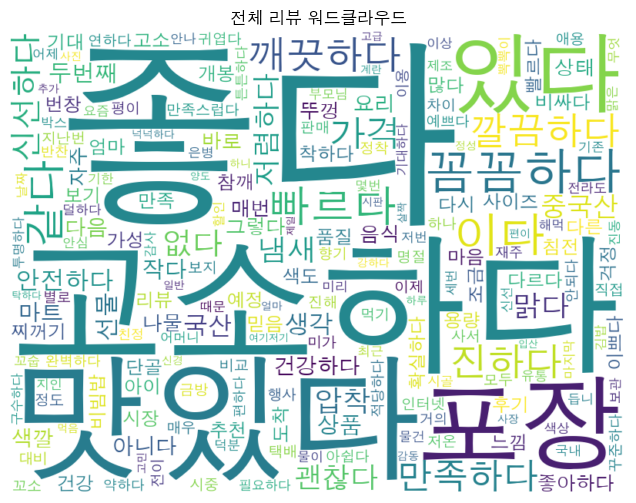

In [76]:
# 전체 단어 수집
all_words = df['토큰'].sum()
word_freq = Counter(all_words)

# 워드클라우드 생성
wc = WordCloud(font_path='AppleGothic.ttf', background_color='white', width=800, height=600)
wc.generate_from_frequencies(word_freq)

# 시각화
plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('전체 리뷰 워드클라우드')
plt.show()

리뷰 클러스터링

In [74]:
# 토큰 문자열로 합치기
df['토큰_문자열'] = df['토큰'].apply(lambda x: ' '.join(x))

# 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['토큰_문자열'])

# 클러스터링
k = 3  # 주제 수 설정
model = KMeans(n_clusters=k, random_state=42)
df['클러스터'] = model.fit_predict(X)

# 클러스터별 핵심 단어 출력
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(k):
    print(f'\n🟢 클러스터 {i}의 중심 단어:')
    print(', '.join([terms[ind] for ind in order_centroids[i][:10]]))



🟢 클러스터 0의 중심 단어:
좋다, 포장, 고소하다, 빠르다, 꼼꼼하다, 맛있다, 이다, 만족하다, 깨끗하다, 같다

🟢 클러스터 1의 중심 단어:
맛있다, 고소하다, 좋다, 진하다, 깨끗하다, 신선하다, 포장, 냄새, 깔끔하다, 이다

🟢 클러스터 2의 중심 단어:
있다, 맛있다, 고소하다, 좋다, 깔끔하다, 포장, 신선하다, 매번, 만족하다, 가격
